In [1]:
%reset
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
import numpy as np
import pandas as pd
from scipy import signal
import statistics as stats
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from scipy import stats
import scipy.sparse as sparse

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
def weighted_average(distribution, weights):
    return round(sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights),2)

def import_csv(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1]]
                data.append(columns)

    return data

def import_csv2(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10] ]
                data.append(columns)

    return data

def import_csv3(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10], row[11] ]
                data.append(columns)

    return data

def import_csv4(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4]]
                data.append(columns)

    return data

In [3]:
tcp_cca = (['TcpCubic','TcpBbr', 'TcpQtCol_1.2minRTT', 'TcpQtCol_1.5minRTT',
            'TcpQtColFair_1.2minRTT', 'TcpQtColFair_1.5minRTT'
           ])
BDP = 172
buffer_size = 1727 
print(buffer_size, tcp_cca)

1727 ['TcpCubic', 'TcpBbr', 'TcpQtCol_1.2minRTT', 'TcpQtCol_1.5minRTT', 'TcpQtColFair_1.2minRTT', 'TcpQtColFair_1.5minRTT']


In [4]:
num_flows = 2
cwnd = {}
agg_cwnd = {}
inflight = {}
rtt = {}

for algorithm in tcp_cca:
    cwnd[algorithm] = {}
    agg_cwnd[algorithm] = {}
    inflight[algorithm] = {}
    rtt[algorithm] = {}


    agg_cwnd[algorithm] = {'time': list(), 'agg_cwnd': list(), 'agg_inflight': list(),
                'aveRtt': list(), 'agg_insThruput': list(), 'agg_aveThruput': list(), 
                'agg_insGoodput': list(), 'agg_aveGoodput': list(), 'agg_TxPkts': list(), 
                'agg_ReTxPkts': list(), 'fairness': list(), 'agg_cost': list()}
        
    for i in range(num_flows):
        cwnd[algorithm][i] = {'time': list(), 'cwnd': list(), 'inflight': list(),
                'rtt': list(), 'insThruput': list(), 'aveThruput': list(), 
                'insGoodput': list(), 'aveGoodput': list(), 'TxPkts': list(), 'ReTxPkts': list(), 
                'cost': list()}
                                       
        inflight[algorithm][i] = {'time': list(), 'inflight': list(), 'cwnd': list(), 
                                           'rtt': list(), 'cost': list()}
        rtt[algorithm][i] = {'time': list(), 'rtt': list()}

cwnd_files = []
agg_cwnd_files = []
inflight_files = []
rtt_files = []
                                               
for algorithm in tcp_cca:
    print(algorithm)
    
    agg_cwnd_files.append("../results/multiflows/" + str(algorithm) + "/" + 
                str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
                algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
                "p-" + "Agg" + "-cwnd.data")
    cwnd_flows_files = []
    inflight_flows_files = []
    rtt_flows_files = []
    
    for i in range(num_flows):
        cwnd_flows_files.append("../results/multiflows/" + str(algorithm) + "/" + 
                    str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
                    algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
                    "p-flow" + str(i) + "-cwnd.data")
 #       inflight_flows_files.append("../results/multiflows/" + str(algorithm) + "/" + 
 #                   str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
 #                   algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
 #                   "p-flow" + str(i) + "-inflight.data")
 #       rtt_flows_files.append("../results/multiflows/" + str(algorithm) + "/" + 
 #                       str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
 #                       algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
 #                       "p-flow" + str(i) + "-rtt.data")
        
    cwnd_files.append(cwnd_flows_files)
    inflight_files.append(inflight_flows_files)
    rtt_files.append(rtt_flows_files)



TcpCubic
TcpBbr
TcpQtCol_1.2minRTT
TcpQtCol_1.5minRTT
TcpQtColFair_1.2minRTT
TcpQtColFair_1.5minRTT


In [5]:
print(agg_cwnd_files[0])
print(agg_cwnd_files[1])
print(agg_cwnd_files[2])

../results/multiflows/TcpCubic/2-flows/100Mbps-20ms/1727p-btlqueue/TcpCubic-2-flows-100Mbps-20ms-1727p-Agg-cwnd.data
../results/multiflows/TcpBbr/2-flows/100Mbps-20ms/1727p-btlqueue/TcpBbr-2-flows-100Mbps-20ms-1727p-Agg-cwnd.data
../results/multiflows/TcpQtCol_1.2minRTT/2-flows/100Mbps-20ms/1727p-btlqueue/TcpQtCol_1.2minRTT-2-flows-100Mbps-20ms-1727p-Agg-cwnd.data


In [6]:

for algorithm  in tcp_cca:
    index_alg = tcp_cca.index(algorithm)
    print(algorithm,index_alg)

    agg_cwnd_data_in = import_csv3(agg_cwnd_files[index_alg])
    for row in agg_cwnd_data_in: 
        agg_cwnd[algorithm]['time'].append({row[0]})
        agg_cwnd[algorithm]['agg_cwnd'].append({row[1]})
        agg_cwnd[algorithm]['agg_inflight'].append({row[2]})
        agg_cwnd[algorithm]['aveRtt'].append({row[3]})
        agg_cwnd[algorithm]['agg_insThruput'].append({row[4]})
        agg_cwnd[algorithm]['agg_aveThruput'].append({row[5]})
        agg_cwnd[algorithm]['agg_insGoodput'].append({row[6]})
        agg_cwnd[algorithm]['agg_aveGoodput'].append({row[7]})
        agg_cwnd[algorithm]['agg_TxPkts'].append({row[8]})
        agg_cwnd[algorithm]['agg_ReTxPkts'].append({row[9]})
        agg_cwnd[algorithm]['fairness'].append({row[10]})
        agg_cwnd[algorithm]['agg_cost'].append({row[11]})

    for i in range(num_flows):
        cwnd_data_in = import_csv2(cwnd_files[index_alg][i])
        #inflight_data_in = import_csv4(inflight_files[index_alg][i])
        #rtt_data_in = import_csv(rtt_files[index_alg][i])

        for row in cwnd_data_in:
            cwnd[algorithm][i]['time'].append({row[0]})
            cwnd[algorithm][i]['cwnd'].append({row[1]})
            cwnd[algorithm][i]['inflight'].append({row[2]})
            cwnd[algorithm][i]['rtt'].append({row[3]})
            cwnd[algorithm][i]['insThruput'].append({row[4]})
            cwnd[algorithm][i]['aveThruput'].append({row[5]})
            cwnd[algorithm][i]['insGoodput'].append({row[6]})
            cwnd[algorithm][i]['aveGoodput'].append({row[7]})
            cwnd[algorithm][i]['TxPkts'].append({row[8]})
            cwnd[algorithm][i]['ReTxPkts'].append({row[9]})
            cwnd[algorithm][i]['cost'].append({row[10]})


TcpCubic 0
TcpBbr 1
TcpQtCol_1.2minRTT 2
TcpQtCol_1.5minRTT 3
TcpQtColFair_1.2minRTT 4
TcpQtColFair_1.5minRTT 5


In [7]:
cwnd_time = []
cwnd_value = []
inflight_value = []
rtt_value = []
insThruput_value = []
aveThruput_value = []
insGoodput_value = []
aveGoodput_value = []
cost_value = []

inflight2_time = []
inflight2_value = []
cwnd2_value = []
rtt2_value = []
cost2_value = []
rtt3_time = []
rtt3_value = []

agg_cwnd_time = []
agg_cwnd_value = []
agg_inflight_value = []
agg_rtt_value = []
agg_insThruput_value = []
agg_aveThruput_value = []
agg_insGoodput_value = []
agg_aveGoodput_value = []
fairness_value = []
agg_cost_value = []

for algorithm in tcp_cca:
    print(algorithm)
    cwnd_time_ = []
    cwnd_value_ = []
    inflight_value_ = []
    rtt_value_ = []
    insThruput_value_ = []
    aveThruput_value_ = []
    insGoodput_value_ = []
    aveGoodput_value_ = []
    cost_value_ = []
    

    agg_cwnd_time.append(pd.DataFrame(agg_cwnd[algorithm]['time']))
    agg_cwnd_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_cwnd']))
    agg_inflight_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_inflight']))
    agg_rtt_value.append(pd.DataFrame(agg_cwnd[algorithm]['aveRtt']))
    agg_insThruput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_insThruput']))  
    agg_aveThruput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_aveThruput']))  
    agg_insGoodput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_insGoodput']))  
    agg_aveGoodput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_aveGoodput'])) 
    fairness_value.append(pd.DataFrame(agg_cwnd[algorithm]['fairness'])) 
    agg_cost_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_cost'])) 
    
    
    for i in range(num_flows):
        cwnd_time_.append(pd.DataFrame(cwnd[algorithm][i]['time']))
        cwnd_value_.append(pd.DataFrame(cwnd[algorithm][i]['cwnd']))
        cost_value_.append(pd.DataFrame(cwnd[algorithm][i]['cost']))
        inflight_value_.append(pd.DataFrame(cwnd[algorithm][i]['inflight']))
        rtt_value_.append(pd.DataFrame(cwnd[algorithm][i]['rtt']))
        insThruput_value_.append(pd.DataFrame(cwnd[algorithm][i]['insThruput']))  
        aveThruput_value_.append(pd.DataFrame(cwnd[algorithm][i]['aveThruput']))  
        insGoodput_value_.append(pd.DataFrame(cwnd[algorithm][i]['insGoodput']))  
        aveGoodput_value_.append(pd.DataFrame(cwnd[algorithm][i]['aveGoodput'])) 
        
    cwnd_time.append(cwnd_time_)
    cwnd_value.append(cwnd_value_)
    cost_value.append(cost_value_)
    inflight_value.append(inflight_value_)
    rtt_value.append(rtt_value_)
    insThruput_value.append(insThruput_value_)
    aveThruput_value.append(aveThruput_value_)
    insGoodput_value.append(insGoodput_value_)
    aveGoodput_value.append(aveGoodput_value_)


TcpCubic
TcpBbr
TcpQtCol_1.2minRTT
TcpQtCol_1.5minRTT
TcpQtColFair_1.2minRTT
TcpQtColFair_1.5minRTT


/tmp/ipykernel_30567/2329694119.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


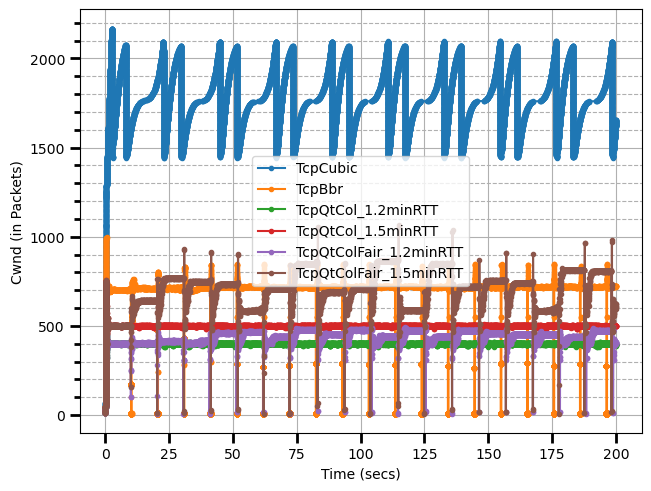

In [8]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[0].to_numpy(dtype=float), agg_cwnd_value[0].to_numpy(dtype=float)/1448.0, '.-',
        agg_cwnd_time[1].to_numpy(dtype=float), agg_cwnd_value[1].to_numpy(dtype=float)/1448,'.-',
        agg_cwnd_time[2].to_numpy(dtype=float), agg_cwnd_value[2].to_numpy(dtype=float)/1448,'.-',
        agg_cwnd_time[3].to_numpy(dtype=float), agg_cwnd_value[3].to_numpy(dtype=float)/1448,'.-',
        agg_cwnd_time[4].to_numpy(dtype=float), agg_cwnd_value[4].to_numpy(dtype=float)/1448,'.-',
        agg_cwnd_time[5].to_numpy(dtype=float), agg_cwnd_value[5].to_numpy(dtype=float)/1448,'.-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_cwnd_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Cwnd (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,800)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[2], tcp_cca[3], tcp_cca[4], tcp_cca[5]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_cwnd.png', transparent=True)


/tmp/ipykernel_30567/3399532110.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


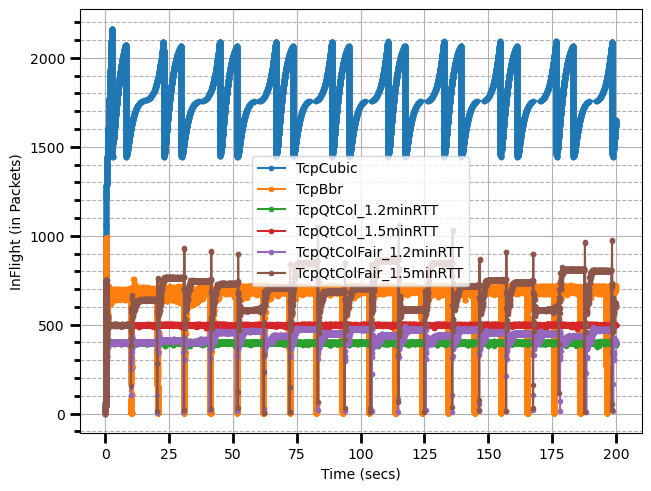

In [9]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[0].to_numpy(dtype=float), agg_inflight_value[0].to_numpy(dtype=float)/1448.0, '.-',
        agg_cwnd_time[1].to_numpy(dtype=float), agg_inflight_value[1].to_numpy(dtype=float)/1448,'.-',
        agg_cwnd_time[2].to_numpy(dtype=float), agg_inflight_value[2].to_numpy(dtype=float)/1448,'.-',
        agg_cwnd_time[3].to_numpy(dtype=float), agg_inflight_value[3].to_numpy(dtype=float)/1448,'.-',
        agg_cwnd_time[4].to_numpy(dtype=float), agg_inflight_value[4].to_numpy(dtype=float)/1448,'.-',
        agg_cwnd_time[5].to_numpy(dtype=float), agg_inflight_value[5].to_numpy(dtype=float)/1448,'.-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_inflight_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'InFlight (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,800)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[2], tcp_cca[3], tcp_cca[4], tcp_cca[5]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_inflight.png', transparent=True)

/tmp/ipykernel_30567/63016658.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


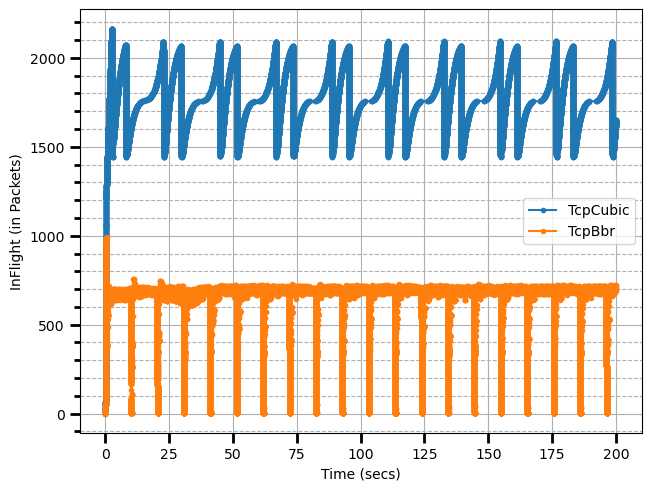

In [10]:
ig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[0].to_numpy(dtype=float), agg_inflight_value[0].to_numpy(dtype=float)/1448.0, '.-',
        agg_cwnd_time[1].to_numpy(dtype=float), agg_inflight_value[1].to_numpy(dtype=float)/1448,'.-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_inflight_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'InFlight (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,800)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_inflight_for_bbr_and_cubic.png', transparent=True)

/tmp/ipykernel_30567/1764845817.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


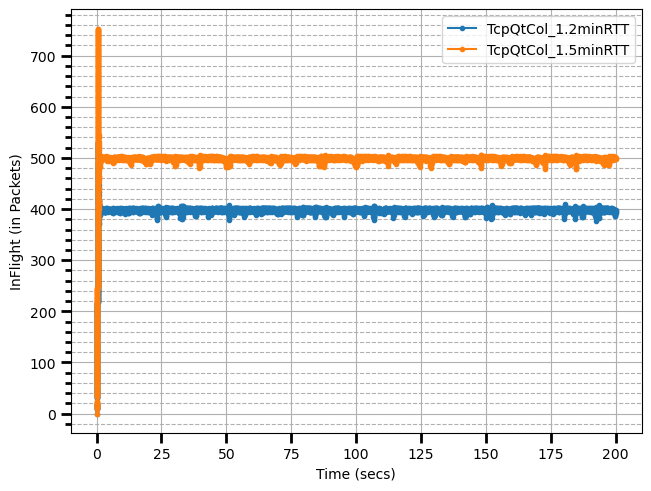

In [11]:
ig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[2].to_numpy(dtype=float), agg_inflight_value[2].to_numpy(dtype=float)/1448,'.-',
        agg_cwnd_time[3].to_numpy(dtype=float), agg_inflight_value[3].to_numpy(dtype=float)/1448,'.-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_inflight_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'InFlight (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,800)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[2], tcp_cca[3]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_inflight_for_qtcol.png', transparent=True)

/tmp/ipykernel_30567/3230236260.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


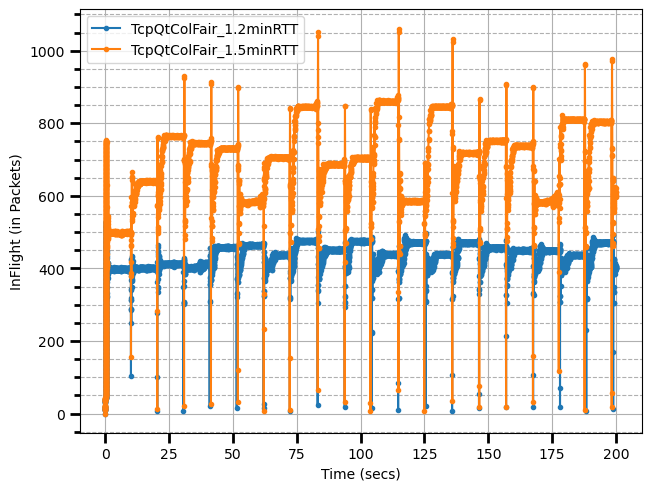

In [12]:
ig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[4].to_numpy(dtype=float), agg_inflight_value[4].to_numpy(dtype=float)/1448,'.-',
        agg_cwnd_time[5].to_numpy(dtype=float), agg_inflight_value[5].to_numpy(dtype=float)/1448,'.-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_inflight_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'InFlight (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,800)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[4], tcp_cca[5]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_inflight_for_qtcolfair.png', transparent=True)

/tmp/ipykernel_30567/2593489225.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


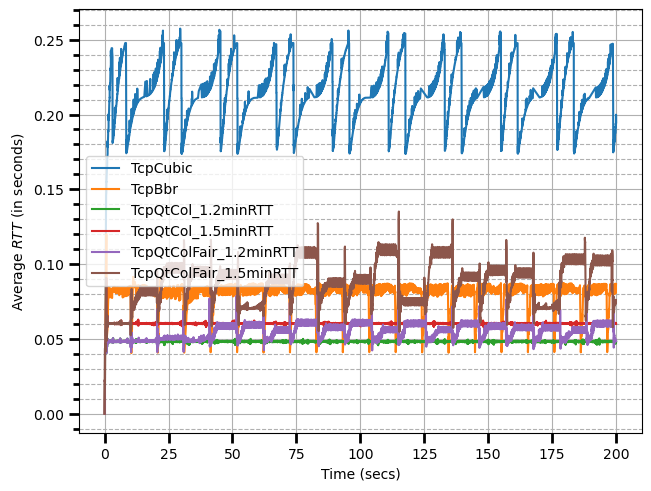

In [13]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[0].to_numpy(dtype=float), agg_rtt_value[0].to_numpy(dtype=float), '-',
        agg_cwnd_time[1].to_numpy(dtype=float), agg_rtt_value[1].to_numpy(dtype=float),'-',
        agg_cwnd_time[2].to_numpy(dtype=float), agg_rtt_value[2].to_numpy(dtype=float),'-',
        agg_cwnd_time[3].to_numpy(dtype=float), agg_rtt_value[3].to_numpy(dtype=float),'-',
        agg_cwnd_time[4].to_numpy(dtype=float), agg_rtt_value[4].to_numpy(dtype=float),'-',
        agg_cwnd_time[5].to_numpy(dtype=float), agg_rtt_value[5].to_numpy(dtype=float),'-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_rtt_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average $RTT$ (in seconds)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,800)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[2], tcp_cca[3], tcp_cca[4], tcp_cca[5]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_rtt.png', transparent=True)

/tmp/ipykernel_30567/3842636408.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


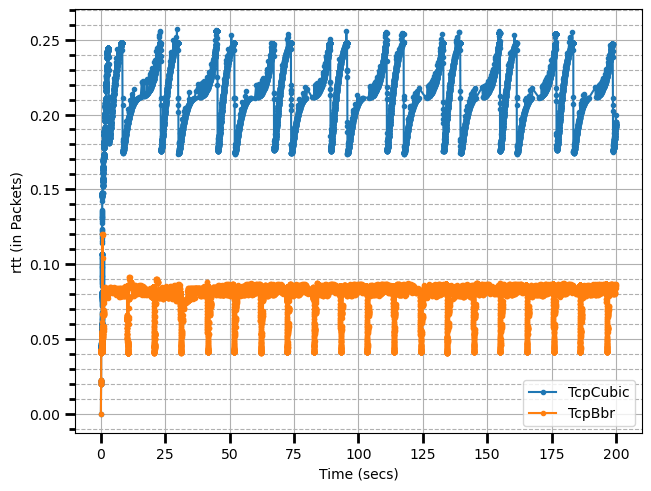

In [14]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[0].to_numpy(dtype=float), agg_rtt_value[0].to_numpy(dtype=float), '.-',
        agg_cwnd_time[1].to_numpy(dtype=float), agg_rtt_value[1].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_rtt_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'rtt (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,800)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_rtt_for_bbr_and_cubic.png', transparent=True)

/tmp/ipykernel_30567/173800819.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


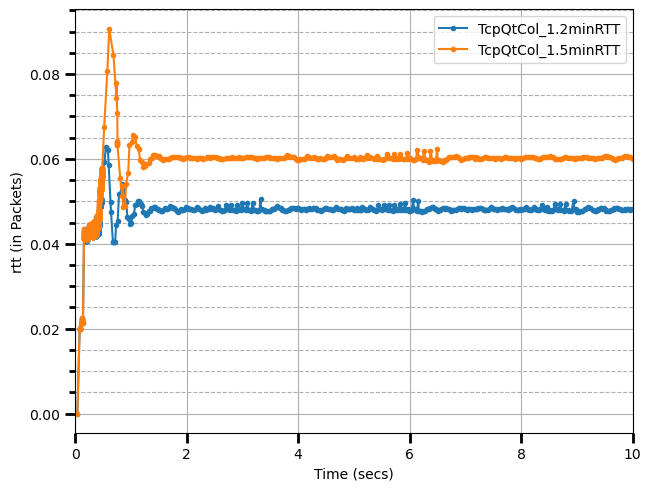

In [15]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[2].to_numpy(dtype=float), agg_rtt_value[2].to_numpy(dtype=float),'.-',
        agg_cwnd_time[3].to_numpy(dtype=float), agg_rtt_value[3].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_rtt_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'rtt (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,800)
plt.xlim(0,10)
plt.grid(True)
plt.legend([
            tcp_cca[2], tcp_cca[3]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_rtt_for_qtcol.png', transparent=True)

/tmp/ipykernel_30567/459368318.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


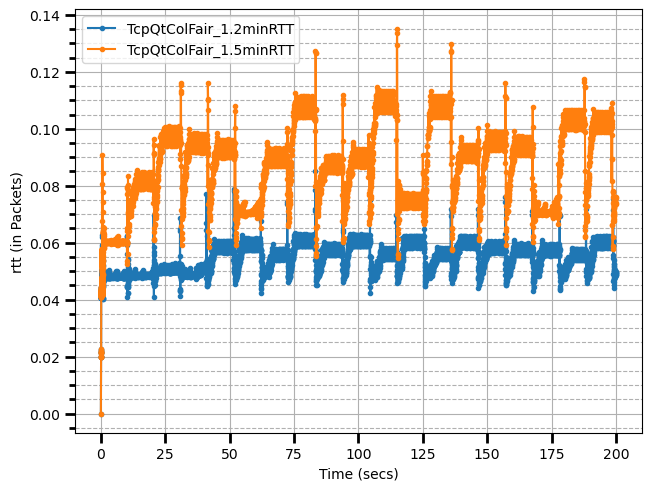

In [16]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[4].to_numpy(dtype=float), agg_rtt_value[4].to_numpy(dtype=float),'.-',
        agg_cwnd_time[5].to_numpy(dtype=float), agg_rtt_value[5].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_rtt_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'rtt (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,800)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[4], tcp_cca[5]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_rtt_for_all.png', transparent=True)

/tmp/ipykernel_30567/2191863221.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


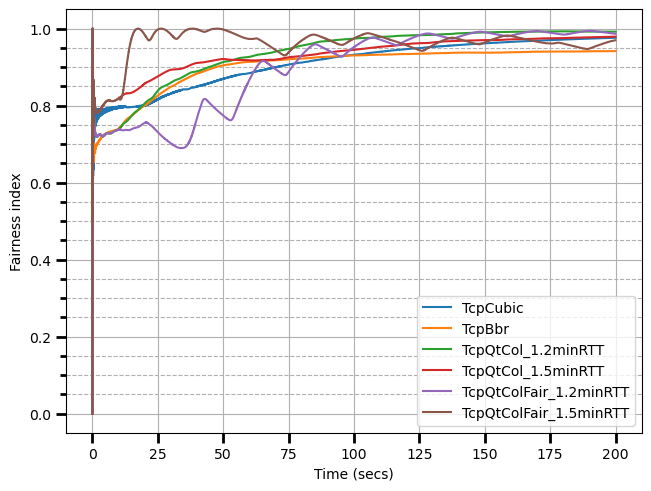

In [17]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[0].to_numpy(dtype=float), fairness_value[0].to_numpy(dtype=float), '-',
        agg_cwnd_time[1].to_numpy(dtype=float), fairness_value[1].to_numpy(dtype=float),'-',
        agg_cwnd_time[2].to_numpy(dtype=float), fairness_value[2].to_numpy(dtype=float),'-',
        agg_cwnd_time[3].to_numpy(dtype=float), fairness_value[3].to_numpy(dtype=float),'-',
        agg_cwnd_time[4].to_numpy(dtype=float), fairness_value[4].to_numpy(dtype=float),'-',
        agg_cwnd_time[5].to_numpy(dtype=float), fairness_value[5].to_numpy(dtype=float),'-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), fairness_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Fairness index')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0.5,1.01)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[2], tcp_cca[3], tcp_cca[4], tcp_cca[5]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_fairness.png', transparent=True)

/tmp/ipykernel_30567/3202019814.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


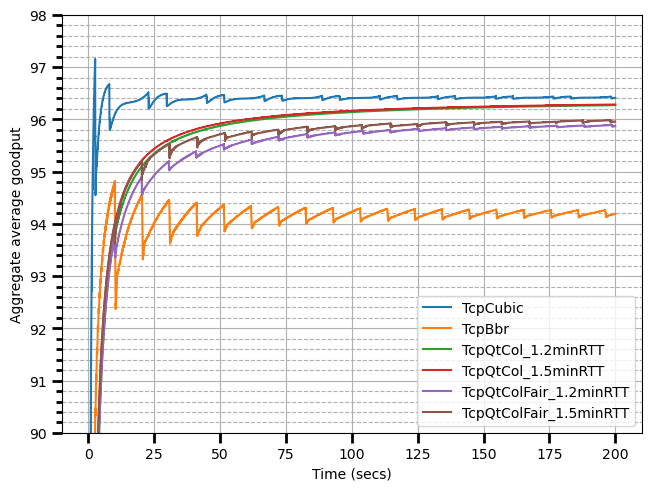

In [18]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[0].to_numpy(dtype=float), agg_aveThruput_value[0].to_numpy(dtype=float), ',-',
        agg_cwnd_time[1].to_numpy(dtype=float), agg_aveThruput_value[1].to_numpy(dtype=float),',-',
        agg_cwnd_time[2].to_numpy(dtype=float), agg_aveThruput_value[2].to_numpy(dtype=float),',-',
        agg_cwnd_time[3].to_numpy(dtype=float), agg_aveThruput_value[3].to_numpy(dtype=float),',-',
        agg_cwnd_time[4].to_numpy(dtype=float), agg_aveThruput_value[4].to_numpy(dtype=float),',-',
        agg_cwnd_time[5].to_numpy(dtype=float), agg_aveThruput_value[5].to_numpy(dtype=float),',-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_aveThruput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Aggregate average goodput')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(90,98)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[2], tcp_cca[3], tcp_cca[4], tcp_cca[5]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_avegoodput_all.png', transparent=True)

/tmp/ipykernel_30567/592513298.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


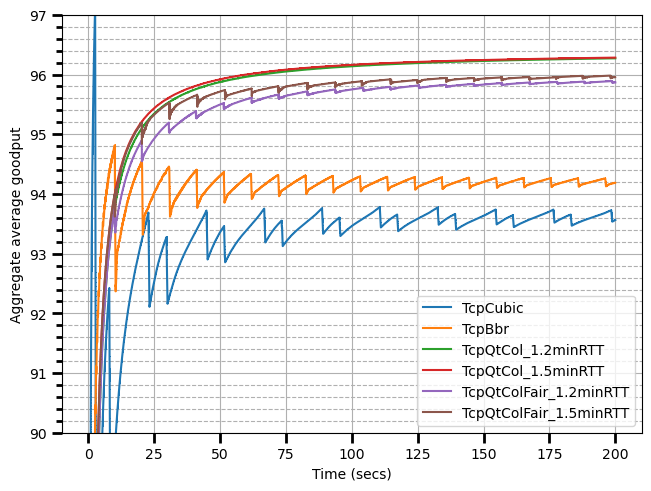

In [19]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        agg_cwnd_time[0].to_numpy(dtype=float), agg_aveGoodput_value[0].to_numpy(dtype=float), ',-',
        agg_cwnd_time[1].to_numpy(dtype=float), agg_aveGoodput_value[1].to_numpy(dtype=float),',-',
        agg_cwnd_time[2].to_numpy(dtype=float), agg_aveGoodput_value[2].to_numpy(dtype=float),',-',
        agg_cwnd_time[3].to_numpy(dtype=float), agg_aveGoodput_value[3].to_numpy(dtype=float),',-',
        agg_cwnd_time[4].to_numpy(dtype=float), agg_aveGoodput_value[4].to_numpy(dtype=float),',-',
        agg_cwnd_time[5].to_numpy(dtype=float), agg_aveGoodput_value[5].to_numpy(dtype=float),',-',
        )
#ax1.step(
#        agg_cwnd_time[1].to_numpy(dtype=float), agg_aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Aggregate average goodput')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(90,97)
#plt.xlim(0,40)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[2], tcp_cca[3], tcp_cca[4], tcp_cca[5]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_agg_avegoodput.png', transparent=True)

/tmp/ipykernel_30567/1146127167.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


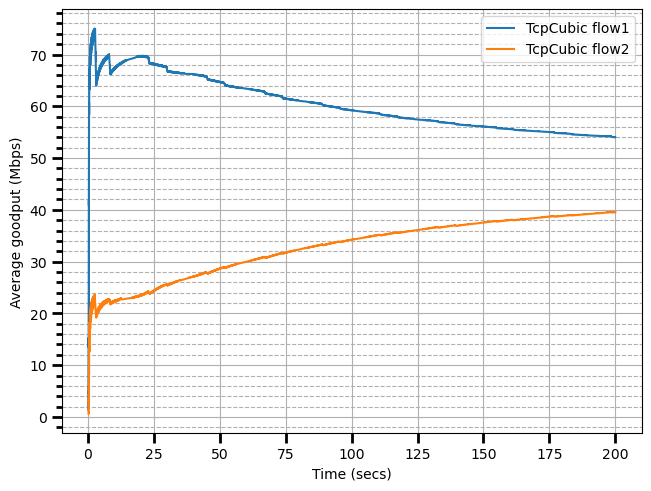

In [20]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), aveGoodput_value[0][0].to_numpy(dtype=float), ',-',
        cwnd_time[0][1].to_numpy(dtype=float), aveGoodput_value[0][1].to_numpy(dtype=float),',-'
        )
#ax1.step(
#        cwnd_time[0].to_numpy(dtype=float), aveGoodput_value[0].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(6,10)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[0] + " flow1", tcp_cca[0] + " flow2"
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_avethruput_cubic_flows.png', transparent=True)

/tmp/ipykernel_30567/765983785.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


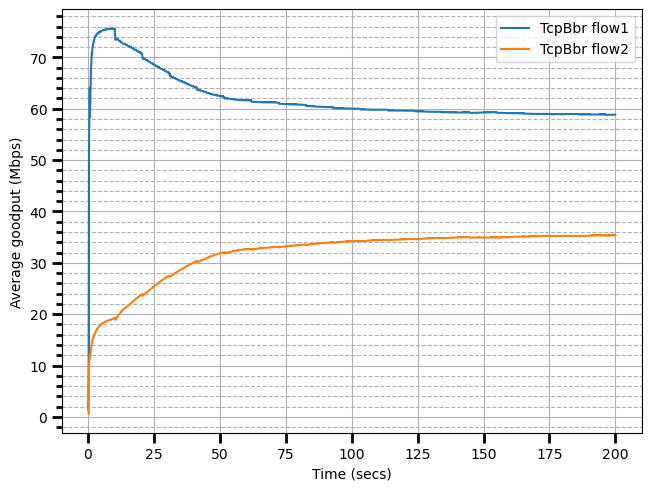

In [21]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[1][0].to_numpy(dtype=float), aveGoodput_value[1][0].to_numpy(dtype=float), ',-',
        cwnd_time[1][1].to_numpy(dtype=float), aveGoodput_value[1][1].to_numpy(dtype=float),',-'
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(6,10)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[1] + " flow1", tcp_cca[1] + " flow2"
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_avethruput_bbr_flows.png', transparent=True)

/tmp/ipykernel_30567/1332900024.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


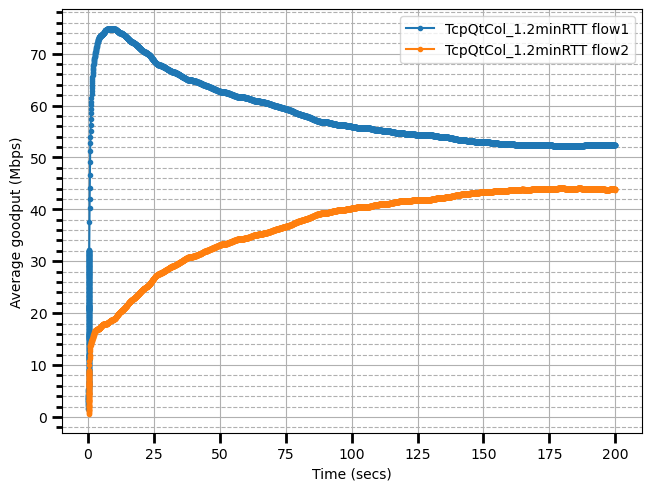

In [22]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[2][0].to_numpy(dtype=float), aveGoodput_value[2][0].to_numpy(dtype=float), '.-',
        cwnd_time[2][1].to_numpy(dtype=float), aveGoodput_value[2][1].to_numpy(dtype=float),'.-'
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(6,10)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[2] + " flow1", tcp_cca[2] + " flow2"
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_avethruput_qtoptimal1.2_flows.png.png', transparent=True)

/tmp/ipykernel_30567/366206705.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


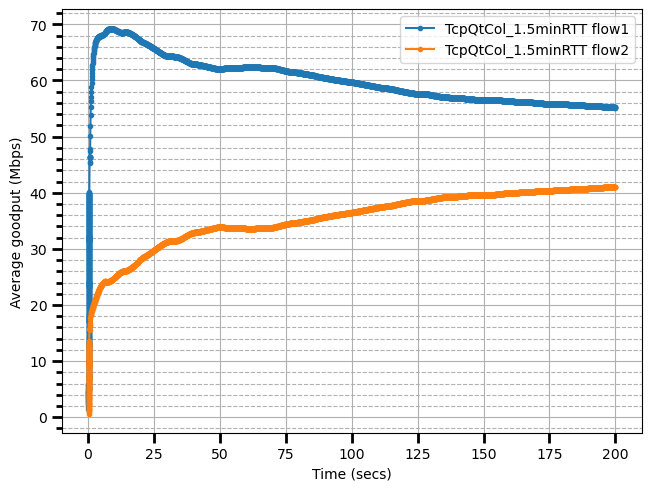

In [23]:
ffig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[3][0].to_numpy(dtype=float), aveGoodput_value[3][0].to_numpy(dtype=float), '.-',
        cwnd_time[3][1].to_numpy(dtype=float), aveGoodput_value[3][1].to_numpy(dtype=float),'.-'
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(6,10)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[3] + " flow1", tcp_cca[3] + " flow2"
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_avethruput_qtoptimal1.2_flows.png.png', transparent=True)

/tmp/ipykernel_30567/604987495.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


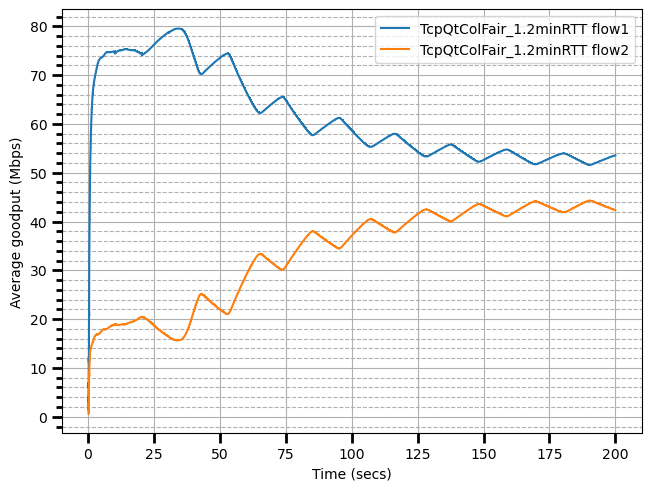

In [24]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[4][0].to_numpy(dtype=float), aveGoodput_value[4][0].to_numpy(dtype=float), ',-',
        cwnd_time[4][1].to_numpy(dtype=float), aveGoodput_value[4][1].to_numpy(dtype=float),',-'
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(6,10)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[4] + " flow1", tcp_cca[4] + " flow2"
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_avethruput_qtoptimal1.2_flows.png.png', transparent=True)

/tmp/ipykernel_30567/3759791877.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


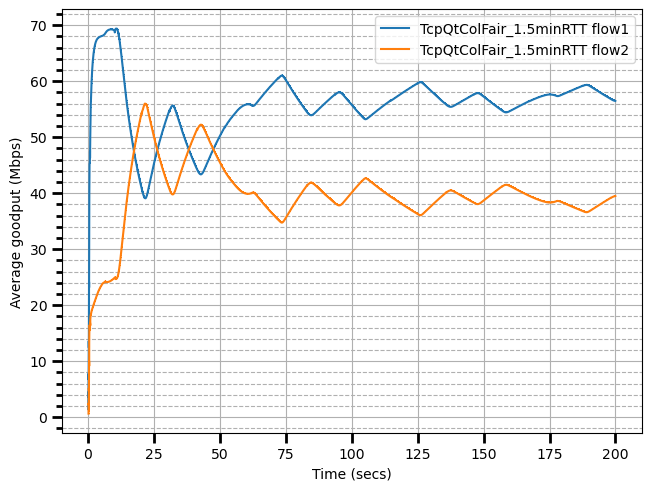

In [25]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[5][0].to_numpy(dtype=float), aveGoodput_value[5][0].to_numpy(dtype=float), ',-',
        cwnd_time[5][1].to_numpy(dtype=float), aveGoodput_value[5][1].to_numpy(dtype=float),',-'
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(6,10)
#plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[5] + " flow1", tcp_cca[5] + " flow2"
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('2-flows_avethruput_qtoptimal1.2_flows.png.png', transparent=True)